# AERM Macro Exam (Candidate Number: 1068576)

Readme: Only the code leading to the main results are presented in this markdown document. All auxiliary functions are in the .jl files contained in this folder and loaded in the preamble. All graphs are saved in the Results folder.

## Exercise 1

In [1]:
# load the required packages
using(LinearAlgebra)
using(Parameters)   
using(Plots)    
using(StatsPlots)
using(TickTock) 

# load predefined functions
include("rouwenhorst.jl")
include("params.jl")
include("solve_v.jl")
include("sim_distn.jl");

### Q1.

I create a stochastic matrix and an income grid based on the Rouwenhorst method coded in rouwenhorst.jl.

In [2]:
ρ         = .88 # persistence of the income process
y_bound   = 1 # log income grid boundary
y_num     = 3 # number of grid points

# call the rouwenhorst function
Π_y, logy = rouwenhorst(ρ, y_bound, y_num)

logy

3-element Vector{Float64}:
 -1.0
  0.0
  1.0

### Q2.

I iteratively solve the stationary distribution from the stochastic matrix.

In [3]:
# load the default parameters
params_ex1 = params_bl();

In [4]:
# define the income distribution with an arbitrary initial distribution
μ = zeros(y_num)
μ[2] = 1

# solve for the stationary distribution
for i in 1:params_ex1.max_iter_KFE
    μ_new = Π_y' * μ
    
    if abs(maximum(μ_new - μ)) < params_ex1.tol_KFE
        break
    end 
    
    μ = μ_new
end 

μ;

In [5]:
# plot the distribution
plot_Q2 = plot(logy, μ, xlabel = "log(y)", ylabel = "f(log(y))", title = "Stationary Income Distribution")
# Save the plot to a folder
savefig(plot_Q2, "results/stationary_income_distribution.png");

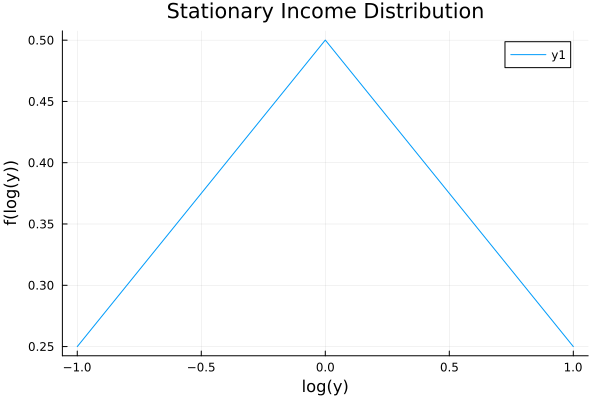

In [6]:
plot_Q2

### Q3.

I compute the unconditional variance of the log labour income distribution from $\sigma_{h}^{2} = E(log(h^{2})) - E(log(h))^2$. Since the stationary distribution and the income grid are symmetric and the midpoint of the income grid is 0, $E(log(h)) = 0$ and the unconditional variance is:

In [7]:
# calculate the unconditional variance of log income
σ² = ceil(μ' * logy.^2, digits = 2)
print(σ²)

0.5

### Q4.

I run the value function solving routine, which also constructs the asset grid.

In [8]:
# set new parameters
B_lower = 0 # in levels
B_upper = exp(y_bound)*20
B_num   = 1000
y_lower = -y_bound # in logs
y_upper = y_bound
y_num   = 3
ϕ       = 0 # sensitivity of utility to asset holding

# update the parameter named tuple
params_ex1 = params_bl(B_lower=B_lower, B_upper=B_upper, B_num=B_num, y_lower=y_lower, y_upper=y_upper, y_num=y_num, ϕ=ϕ);

In [9]:
# run the value function solving routine
v_sol = solve_v(;params=params_ex1, v_int=0);

convergence_v: true


In [10]:
# the resulting asset grid
v_sol.B_grid

1000-element LinRange{Float64, Int64}:
 0.0, 0.0544201, 0.10884, 0.16326, …, 54.2024, 54.2568, 54.3112, 54.3656

### Q5.

I use the output from the value function solver to obtain the consumption policy function.

In [11]:
plot_Q5 = plot(
    v_sol.B_grid,
    [v_sol.c_sol[1:B_num], v_sol.c_sol[(B_num*2+1):B_num*3]],
    label=["low income" "high income"],
    xlabel = "B",
    ylabel = "C(B, h)",
    title = "Consumption Policy Function"
)

savefig(plot_Q5, "results/consumption_policy_function.png");

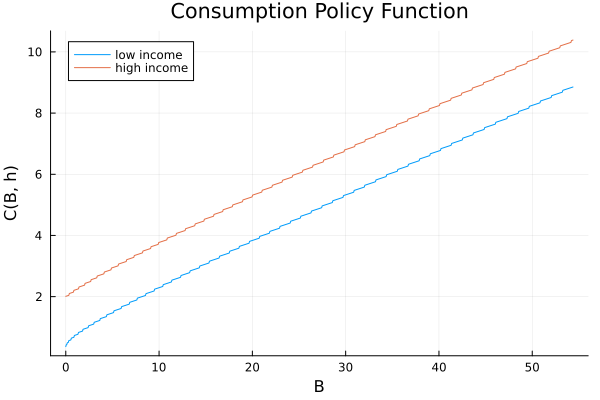

In [12]:
plot_Q5

### Q6.

I compute average household savings by income group. I first create a matrix s(b,h) of household savings (dim: y_num x B_num), according to:

$$
\begin{align}
s(b,h) = \frac{h + rb - c}{h + rb}
\end{align}
$$

In [13]:
# create a matrix s(b,h) of household savings (dim: y_num x B_num):

# retrieve the interest rate
r = params_ex1.r

# retrieve the policy function
c = v_sol.c_sol

# begin by expanding each grid
h = kron(v_sol.y_grid, ones(B_num))
b = kron(ones(y_num), v_sol.B_grid)
#b = v_sol.B_next

# compute s(b,h)
s_bh = (h + r*b - c)./(h + r*b);

I obtain the stationary distribution $\mu(b,h)$ using the iterative solver sim_distn.jl (see .jl file for a full description).

In [14]:
μ_bh = solve_g(;sol_v=v_sol,x_int=0,params=params_ex1)[2];

CONV stationary distn. after 121 iterations.


In [15]:
# normalise the distribution within income types, such that ∑_{b ∈ B} μ(b | h) = 1 for ∀h ∈ H
μ_bh_norm = [μ_bh[(B_num*(i-1)+1):(B_num*i)] / μ[i] for i in 1:y_num];

In [16]:
# run some sanity checks
(round(sum(μ_bh_norm[1])) == 1 && round(sum(μ_bh_norm[2])) == 1 && round(sum(μ_bh_norm[3])) == 1)

true

In [17]:
# convert into a single y_num x B_num vector
μ_bh_norm = vcat(μ_bh_norm...); 
# note: here, ... is the splats operator: it unpacks μ_bh_norm into 3 distinct arguments. This is equivalent to vcat(μ_bh_norm[1], μ_bh_norm[2], μ_bh_norm[3])

Next, I compute the average household savings by income group with:

$$
\begin{align}
\tilde{s}(h) = \sum_{b \in B} s(b,h)\cdot \mu(b,h)
\end{align}
$$

In [18]:
# compute s(h) using the stationary distribution
s_h = [s_bh[(B_num*(i-1)+1):(B_num*i)]' * μ_bh_norm[(B_num*(i-1)+1):(B_num*i)] for i in 1:y_num];

In [19]:
# plot the average savings by income group:
plot_Q6 = bar(["Low", "Medium", "High"], s_h, xlabel = "income level", ylabel = "s(h)", title = "Average Savings by Income Group", ylim = (-.25, .2));
savefig(plot_Q6, "results/average_savings_part1.png");

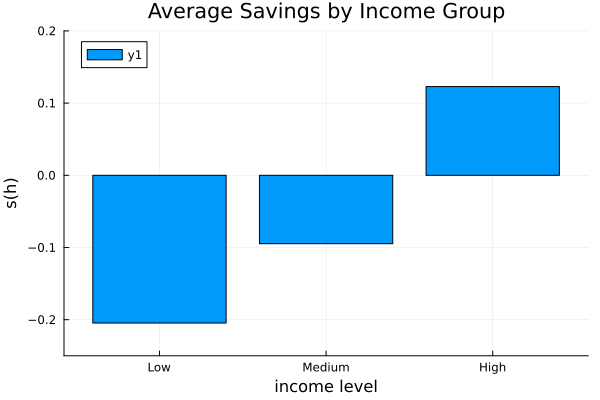

In [20]:
plot_Q6

The savings rate is increasing in income because higher income households build their precautionary savings in expectation of future shocks. Since households hit by a negative shock are imperfectly insured, their savings rate is negative as they consume from their asset buffer to smooth consumption. 

## Exercise 2

### Q1.

I update the parameters to include the non-homothetic asset holding motive.

In [21]:
ϕ = .13
κ = 1.5

params_ex2 = params_bl(B_lower=B_lower, B_upper=B_upper, B_num=B_num, y_lower=y_lower, y_upper=y_upper, y_num=y_num, κ=κ, ϕ=ϕ);

### Q2.

I run the value function solving routine with the new parameters to obtain the consumption policy funtion.

In [22]:
# run the value function solving routine
v_sol2 = solve_v(;params=params_ex2, v_int=0);

convergence_v: true


In [43]:
plot_Q22 = plot(
    v_sol2.B_grid,
    [v_sol2.c_sol[1:B_num], v_sol2.c_sol[(B_num*2+1):B_num*3]],
    label=["low income w/ asset holding motive" "high income w/ asset holding motive"],
    linestyle=:solid,
    color = [:blue :red],
    xlabel = "B",
    ylabel = "C(B, h)",
    title = "Consumption Policy Functions"
)

plot!(
    v_sol.B_grid,
    [v_sol.c_sol[1:B_num], v_sol.c_sol[(B_num*2+1):B_num*3]],
    label=["low income w/o asset holding motive" "high income w/o asset holding motive"],
    linestyle=:dash,
    color = [:blue :red],
)

savefig(plot_Q22, "results/consumption_policy_function_non_homothetic.png");

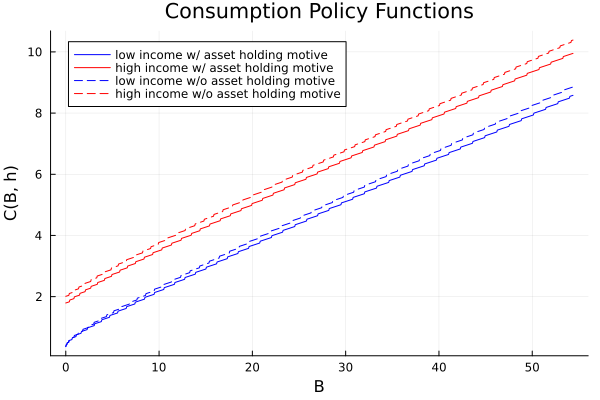

In [44]:
plot_Q22

The consumption policy function under non-homothetic utility looks almost identical to the policy function without assets in the utility function.

### Q3.

I run the same algorithm as in Exercise 1 with the new policy functions.

In [26]:
# retrieve the policy function
c2 = v_sol2.c_sol

# begin by expanding each grid
h2 = kron(v_sol2.y_grid, ones(B_num))
b2 = kron(ones(y_num), v_sol2.B_grid)
#b2 = v_sol2.B_next

# compute s(b,h)
s_bh2 = (h2 + r*b2 - c2)./(h2 + r*b2)

# obtain the stationary distribution
μ_bh2 = solve_g(;sol_v=v_sol2,x_int=0,params=params_ex2)[2]

# normalise the distribution within income types, such that ∑_{b ∈ B} μ(b | h) = 1 for ∀h ∈ H
μ_bh_norm2 = [μ_bh2[(B_num*(i-1)+1):(B_num*i)] / μ[i] for i in 1:y_num];

CONV stationary distn. after 131 iterations.


In [27]:
# run some sanity checks
(round(sum(μ_bh_norm2[1])) == 1 && round(sum(μ_bh_norm2[2])) == 1 && round(sum(μ_bh_norm2[2])) == 1)

true

In [28]:
# convert into a single y_num x B_num vector
μ_bh_norm2 = vcat(μ_bh_norm2...) 

# compute s(h) using the stationary distribution
s_h2 = [s_bh2[(B_num*(i-1)+1):(B_num*i)]' * μ_bh_norm2[(B_num*(i-1)+1):(B_num*i)] for i in 1:y_num];

In [29]:
# plot the average savings by income group:
plot_Q32 = groupedbar(
    ["Low", "Medium", "High"], 
    [s_h s_h2], 
    label = ["no asset holding motive" "asset holding motive"],
    xlabel = "income level", 
    ylabel = "s(h)", 
    title = "Average Savings by Income Group", 
    ylim = (-.4, .2)
)

savefig(plot_Q32, "results/average_savings_part2.png");

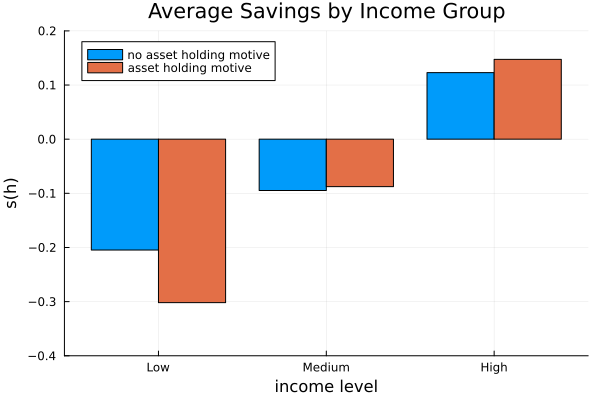

In [30]:
plot_Q32

### Q4.

With non-homothetic preferences for assets, high income households save more but low income households save less. This is because assets are now luxury goods, so that high income housholds have an incentive to hold more assets on top of their precautionary savings motive. Moreover, a stronger saving motive for high income households means that they have more asset buffer when they are hit by a negative income shock. Therefore, low income households, who have a higher marginal utility of consumption than asset holding, can afford to save less (i.e. eat in the buffer) to smooth consumption.